In [2]:
%%time
import manager_dataset as MD
import question_processing as QP
import information_retrieval as IR
import named_entity_recognition as NER
import answer_processing as AP
from gensim.models import KeyedVectors
from util import util

Wall time: 7.68 s


In [1]:
import warnings
warnings.filterwarnings('ignore')

### Settings

Questions recive all the questions treated

In [3]:
questions = MD.questions(treated=True)
incosiderate_classes = ['X', 'MANNER', 'OTHER', ]
questions = QP.remove_incosiderate_classes(questions, incosiderate_classes)  # Question with incosiderate class is removed

Remove question with empty text

In [4]:
ret = []
for question in questions:
    if question['question'] is None or question['question'].strip() == '':
        continue
    ret.append(question)
questions = ret

In [5]:
classes ={}
for question in questions:
    if question['class'] not in classes:
        classes[question['class']] = 0
    classes[question['class']] += 1
classes

{'DEFINITION': 650,
 'LOCATION': 545,
 'MEASURE': 502,
 'OBJECT': 86,
 'ORGANIZATION': 356,
 'PERSON': 582,
 'TIME': 364}

In [7]:
classes ={}
t = 0
for question in questions:
    if question['category'] not in classes:
        classes[question['category']] = 0
    classes[question['category']] += 1
    t += 1
print(classes)
print(t)

{'F': 2036, 'D': 492, 'L': 52, 'X': 800, 'OTHER': 42, 'PERSON': 38, 'TIME': 24, 'ORGANIZATION': 16, 'MEASURE': 15, 'LOCATION': 39, 'COUNT': 19, 'OBJECT': 7, 'FACTOID': 609, 'LIST': 77, 'DEFINITION': 110}
4376


In [ ]:
{'LOCATION': , 'OTHER': , 
 'MEASURE': , 'ORGANIZATION': , '': , 'OBJECT': , 
 'COUNT': , 'X': , 'FACTOID': , 'DEFINITION': , 'LIST': }

In [8]:
classes ={}
t = 0
for question in questions:
    if question['type'] not in classes:
        classes[question['type']] = 0
    classes[question['type']] += 1
    t += 1
print(classes)
print(t)

{'TIME': 340, 'PERSON': 778, 'LOCATION': 506, 'OTHER': 571, 'MEASURE': 368, 'ORGANIZATION': 548, 'MANNER': 26, 'OBJECT': 139, 'COUNT': 100, 'X': 800, 'FACTOID': 162, 'DEFINITION': 28, 'LIST': 10}
4376


The questions that has an answer will be used for test while another questions will be used for train.

In [ ]:
train_questions, test_questions = MD.split_questions(questions)

## Question Processing

In [ ]:
train_questions[0].keys()

### Question Classification

Or Load the Word2Vec model

In [ ]:
classes_ = set()
for t in test_questions:
    classes_.add(t['class'])

In [ ]:
%%time
w2v_patch = 'C:\word_embedding\pt_cbow_s300.txt'
#w2v_patch = 'C:\word_embedding\pt_cbow_s50.txt'  # Fast test
w2v = KeyedVectors.load_word2vec_format(w2v_patch, unicode_errors="ignore")
model_w2v = {w: vec for w, vec in zip(w2v.index2word, w2v.syn0)}

In [ ]:
classes_

And Train a SVM model

In [ ]:
%%time
qc_X_train, qc_y_train = QP.separete_questions(train_questions)

classifier = QP.svm_classifier()
vectorizer = QP.HybridVectorizer(model_w2v)
#vectorizer = QP.MeanEmbeddingVectorizer(model_w2v)
#vectorizer = QP.TfidfHybridVectorizer(model_w2v)
#vectorizer = QP.SequenceHybridVectorizer(model_w2v)
#vectorizer = QP.count_vectorizer(model_w2v)
#vectorizer = QP.tfidf_vectorizer(model_w2v)
model = QP.train_model(qc_X_train, qc_y_train, classifier, vectorizer)

Or Loading the the trained SVM model

In [ ]:
%%time
import dill
model = dill.load(open(QP.answer_type_file, 'rb'))

Answer type is predicted for all questions

In [ ]:
%%time
questions = QP.predict_answer_type(model, test_questions)

#### Testing

In [ ]:
qc_X_test, qc_y_test = QP.separete_questions(test_questions)
print('Size train:',len(train_questions),'  Size test:',len(qc_y_test))

In [ ]:
%matplotlib notebook
plt.close()
plt.style.use('default')
confusion_matrix = QP.testing(model, qc_X_test, qc_y_test)
plt_ = QP.plot_confusion_matrix(confusion_matrix, ['LOCATION', 'MEASURE', 'ORGANIZATION', 'PERSON', 'TIME'], normalize=True)

In [ ]:
plt_.savefig('qa_qc_mc.eps', format='eps', dpi=100)

### Query Formulation

All test questions will recive the query for IR module. 

In [ ]:
%%time
test_questions = QP.queryFormulation(test_questions)

## Information Retrieval

### Document Retrieval

In [ ]:
import information_retrieval as IR
ir = IR.InformationRetrieval()

Start the IR module. If the documents was not indexed then they will be.
When reset is True, all indexed documents is removed and indexed again.

In [ ]:
%%time
ir.start(reset=False)

In [ ]:
%%time
test_questions = ir.retrievalDocuments(test_questions)

In [ ]:

MAX_DOCS = QP.MAX_DOCUMENTS_RETRIEVAL

results = []
for m in range(MAX_DOCS):
    results.append([])

for question in test_questions:
    relevants = [a['doc'] for a in question['answers']]
    if len(question['retrieval']) == MAX_DOCS and len(relevants) > 0:
        count = 0
        for i, r in enumerate(question['retrieval']):
            if r in relevants:
                count += 1
            results[i].append(count/(i+1))

In [ ]:
len(results[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_ = list(range(MAX_DOCS))
for i in range(len(x_)):
    x_[i] += 1
y_ = [np.mean(r) for r in results]
std = [np.std(r) for r in results]

plt.close()
plt.style.use('seaborn-paper')
plt.plot(x_, y_)
plt.xlim(1,MAX_DOCS)
plt.title('Precisão Média por Documentos Recuperados', fontsize=14)
plt.xlabel('Documentos Recuperados', fontsize=11)
plt.ylabel('Precisão Média', fontsize=11)
plt.show()

In [ ]:
plt.savefig('qa_ir_doc.eps', format='eps', dpi=100)

#### Testing

In [ ]:
IR.test_ir_system(test_questions)

### Named Entity Recognition

In [9]:
import importlib
importlib.reload(NER)
importlib.reload(NER.CNLP)

<module 'util.corenlp' from 'C:\\Users\\55519\\UFRGS\\QA\\qa-chave\\util\\corenlp.py'>

Train model

In [10]:
%%time
import named_entity_recognition as NER
model_ner = NER.train()

9 / 3319
19 / 3319
29 / 3319
39 / 3319
49 / 3319
59 / 3319
69 / 3319
79 / 3319
89 / 3319
99 / 3319
109 / 3319
119 / 3319
129 / 3319
139 / 3319
149 / 3319
159 / 3319
169 / 3319
179 / 3319
189 / 3319
199 / 3319
209 / 3319
219 / 3319
229 / 3319
239 / 3319
249 / 3319
259 / 3319
269 / 3319
279 / 3319
289 / 3319
299 / 3319
309 / 3319
319 / 3319
329 / 3319
339 / 3319
349 / 3319
359 / 3319
369 / 3319
379 / 3319
389 / 3319
399 / 3319
409 / 3319
419 / 3319
429 / 3319
439 / 3319
449 / 3319
459 / 3319
469 / 3319
479 / 3319
489 / 3319
499 / 3319
509 / 3319
519 / 3319
529 / 3319
539 / 3319
549 / 3319
559 / 3319
569 / 3319
579 / 3319
589 / 3319
599 / 3319
609 / 3319
619 / 3319
629 / 3319
639 / 3319
649 / 3319
659 / 3319
669 / 3319
679 / 3319
689 / 3319
699 / 3319
709 / 3319
719 / 3319
729 / 3319
739 / 3319
749 / 3319
759 / 3319
769 / 3319
779 / 3319
789 / 3319
799 / 3319
809 / 3319
819 / 3319
829 / 3319
839 / 3319
849 / 3319
859 / 3319
869 / 3319
879 / 3319
889 / 3319
899 / 3319
909 / 3319
919 / 3319

In [ ]:
{'O': 74934, 'VALOR-B': 463, 'VALOR-I': 467}

Or load model

In [ ]:
%%time
import named_entity_recognition as NER
import dill
model_ner = dill.load(open(NER.file_ner, 'rb'))

#### Testing

In [ ]:
NER.test_approach()

In [ ]:
NER.predict(model_ner, u'No Brasil, mora o aluno Eduardo Cortes. Ele estuda na UFRGS em Porto Alegre')[0]

### Passage Retrieval

In [ ]:
%%time
test_questions = IR.retrievalPassagesQuestions(test_questions, model_ner, ir)

In [ ]:
for p in test_questions[0]['passages']:
    print(p['passage_score'])

In [370]:

MAX_ = 100

results = []
for m in range(MAX_):
    results.append([])

for question in test_questions:
    relevants = []
    for a in question['answers']:
        if a['answer'] is not None:
            relevants.append(a['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip())
    question['passages'].sort(key=lambda x: x['passage_score'], reverse=True)
    if len(question['passages']) >= MAX_ and len(relevants) > 0:
        count = 0
        for i in range(MAX_):
            for relevant in relevants:
                a_ = question['passages'][i]['passage'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip()
                if a_ in relevant or relevant in a_:
                    count += 1
                    break
            results[i].append(count/(i+1))

<IPython.core.display.Javascript object>


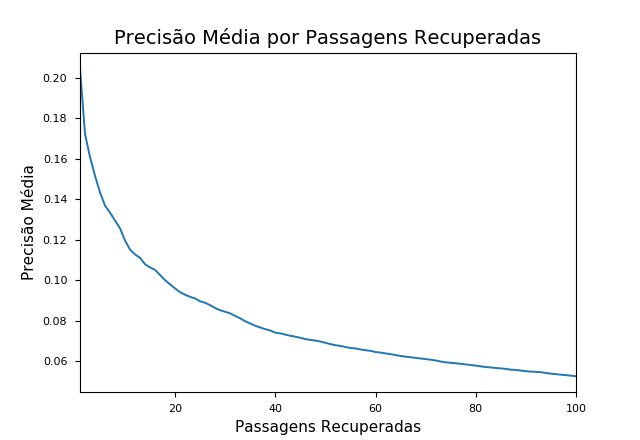

In [371]:
import numpy as np
import matplotlib.pyplot as plt

x_ = list(range(MAX_))
for i in range(len(x_)):
    x_[i] += 1
y_ = [np.mean(r) for r in results]
std = [np.std(r) for r in results]

plt.close()
plt.style.use('seaborn-paper')
plt.plot(x_, y_)
#plt.errorbar(x_, y_, std)
plt.xlim(1,MAX_)
plt.title('Precisão Média por Passagens Recuperadas', fontsize=14)
plt.xlabel('Passagens Recuperadas', fontsize=11)
plt.ylabel('Precisão Média', fontsize=11)
plt.show()

In [ ]:
results[1]

In [372]:
plt.savefig('qa_ir_passage.eps', format='eps', dpi=100)

## Answer Processing

In [ ]:
test_questions[0]['answers'][]

### Answer Extraction

In [ ]:
%%time
test_questions = AP.answer_candidates(test_questions, ir, model_ner)

### Final Answer Selection

In [ ]:
%%time
test_questions = AP.finals_answer(test_questions)
#for c in test_questions[0]['answer_candidates']:
#    print(c['passage_score'])

In [ ]:
print(test_questions[0]['question'])
print(test_questions[0]['query'])
print(test_questions[0]['answers'])
#for ac in test_questions[1]['answer_candidates']:
#    print(float(("%0.1f"%ac['doc_rank'])), float(("%0.1f"%ac['votes'])), float(("%0.1f"%ac['score'])))


In [ ]:
import pprint
pp = pprint.PrettyPrinter()
pp.pprint(test_questions[0])

#### Testing

In [ ]:
test_questions[0]['query']['q']

Check if the answer_candidates have the right answer

In [ ]:
AP.test_answer_candidates(test_questions)

In [366]:
MAX_ = 200

results = []
for m in range(MAX_):
    results.append([])

for question in test_questions:
    #relevants = [a['answer'] for a in question['answers'] if a['answer'] is not None]
    relevants = []
    for a in question['answers']:
        if a['answer'] is not None:
            relevants.append(a['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip())
        
    question['answer_candidates'].sort(key=lambda x: x['score'], reverse=True)
    if len(question['answer_candidates']) >= MAX_ and len(relevants) > 0:
        count = 0
        for i in range(MAX_):
            for relevant in relevants:
                a_ = question['answer_candidates'][i]['full_answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').replace('\n','').replace('\r','').replace('\t','').strip()
                if a_ in relevant or relevant in a_:
                    count += 1
                    break
            results[i].append(count/(i+1))

In [ ]:
test_questions[0]['answers']

<IPython.core.display.Javascript object>


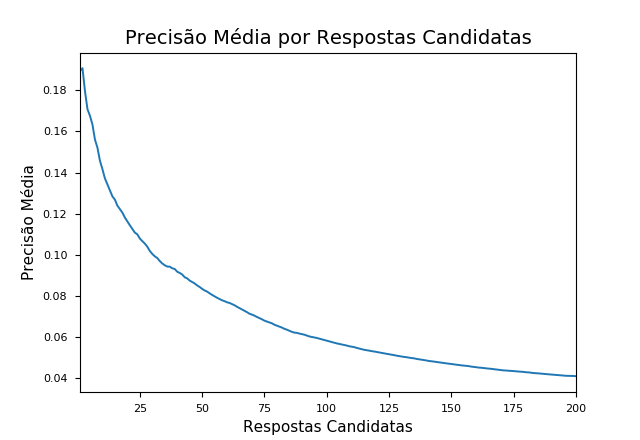

In [367]:
import numpy as np
import matplotlib.pyplot as plt

x_ = list(range(MAX_))
for i in range(len(x_)):
    x_[i] += 1
y_ = [np.mean(r) for r in results]
std = [np.std(r) for r in results]

plt.close()
plt.style.use('seaborn-paper')
plt.plot(x_, y_)
#plt.errorbar(x_, y_, std)
plt.xlim(1,MAX_)
plt.title('Precisão Média por Respostas Candidatas', fontsize=14)
plt.xlabel('Respostas Candidatas', fontsize=11)
plt.ylabel('Precisão Média', fontsize=11)
plt.show()

In [368]:
plt.savefig('qa_ir_answers.eps', format='eps', dpi=100)

## Final Evaluate

In [ ]:
total = len(test_questions)
right = 0

cc_total = 0  # Total of question with correct candidates
cc_right = 0

for question in test_questions:
    aux = False
    if question['correct_answers_candidates']:
        aux = True
        cc_total += 1
    question['correct_final_answer'] = False
    for answer in question['answers']:
        if answer['answer'] is not None:
            a1 = answer['answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            a2 = question['final_answer'].lower().replace(',', '').replace('.', '').replace(';', '').replace('(','').replace(')','').replace(u'«','').replace(u'»','').strip()
            if a1 in a2 or a2 in a1:
                question['correct_final_answer'] = True
                right += 1
                if aux:
                    cc_right += 1
                break
print(str(total) + ' / ' + str(right))
print('Accuracy: '+ '%.3f' % ((right/total)*100)+' %')
print('\nCorrect answer candidates:\n' + str(cc_total) + ' / ' + str(cc_right))
print('Accuracy: '+ '%.3f' % ((cc_right/cc_total)*100)+' %')

Question Analysis

In [ ]:
print('Q = Question\nSA = System Answer\nCA = Correct Answer(s)')


print('\n##### Correct Answers #####\n')
for i in range(len(test_questions)):
    if test_questions[i]['correct_final_answer']:
        print('Index: ' + str(i))
        print('Q: ' + test_questions[i]['question'])
        print('SA: ' + test_questions[i]['final_answer'])
        print('CA: ', end='')
        for answer in test_questions[i]['answers']:
            if answer['answer'] is not None:
                print(answer['answer'].strip(), end=' | ')
        print('\n')


    


In [ ]:
print('\n##### Wrong Answers #####\n')
for i in range(len(test_questions)):
    if not test_questions[i]['correct_final_answer']:
        print('Index: ' + str(i))
        print('Q: ' + test_questions[i]['question'])
        print('SA: ' + test_questions[i]['final_answer'])
        print('CA: ', end='')
        for answer in test_questions[i]['answers']:
            if answer['answer'] is not None:
                print(answer['answer'].strip(), end=' | ')
        print('\n')


In [ ]:
for c in test_questions[0]['answer_candidates']:
    print(c['score'], c['votes'])

In [ ]:
sorted(test_questions[0]['answer_candidates'], key=lambda k: k['score'])[-1]

## Util

### Detailed Question Analysis

In [ ]:
question = {
    'question': u'Onde era o campo de concentração de Auschwitz?',
    'class': 'LOCATION'
}

question = test_questions[28]

print('Question: ' + question['question'])
print('Class: ' + question['class'])

# Question Classification
QP.predict_answer_type(model, [question])
print('Answer Type: ' + question['predict_class'])

# Query Formulation
QP.queryFormulation([question])
print('Query: ' + question['query']['q'])

# Document Retrieval
ir.retrievalDocuments([question])
print('Number of retrieval documents: ' + str(len(question['retrieval'])))

# Passages Retrieval
IR.retrievalPassagesQuestions([question], model_ner, ir)

# Answers Candidates
AP.answer_candidates([question], QP, ir, NER, model_ner)
print('Number of answer candidates: ' + str(len(question['answer_candidates'])))

# Final Answer
AP.finals_answer([question])
print('Answer: ' + question['final_answer'])

if 'answers' in question:
    print('Correct Answers: ', end='')
    for answer in question['answers']:
        if answer['answer'] is not None:
            print(answer['answer'].strip(), end=' | ')

In [ ]:
for p in question['passages']:
    print(p['doc_id'],'\n',p['passage'], '\n')

Show documents id

In [ ]:
print('Retrieval Documents ID: ', end='')
for doc_id in question['retrieval']:
    print(doc_id, end=', ')

if 'answers' in question:
    print('\n\nRelevants Documents ID: ', end='')
    for answer in question['answers']:
        if answer['doc'] is not None and len(answer['doc']) > 0:
            print(answer['doc'], end=', ')

Show documents texts

In [ ]:
for doc_id in question['retrieval']:
    print('\n'+doc_id+'\n'+ir.documentText(doc_id))

In [ ]:
doc_id = 'PUBLICO-19940929-035'
print('\n'+doc_id+'\n'+ir.documentText(doc_id))

Show answers candidates

In [ ]:
for ac in question['answer_candidates']:
    print(ac['full_answer'])

Show most vote answer candidates

In [ ]:
import operator
votes = {}
for candidate in question['answer_candidates']:
    if candidate['full_answer'].lower() not in question['question'].lower():
        if candidate['full_answer'] not in votes:
            votes[candidate['full_answer']] = candidate['score']
[(k, votes[k]) for k in sorted(votes, key=votes.get, reverse=True)]

In [ ]:
for x in sorted(question['answer_candidates'], key=lambda k: k['score'])[::-1]:
    print(float(("%0.2f"%x['doc_rank'])), float(("%0.2f"%x['votes'])), float(("%0.2f"%x['score'])))  

In [ ]:
NER.predict(model_ner, u'Michael Jackson casou-se com a filha de Elvis Presley')[0]

### Others

In [ ]:
ir.stop()

In [ ]:
import importlib
importlib.reload(AP)
#raise IpyExit

In [ ]:
import CoreNLP

def retrieval_passages(questions, ner_model):
    for question in questions:
        question['passages'] = []
        for document in question['documents']:
            passages = CoreNLP.ssplit(document_text)
            for passage in passages:
                entities = ner_model.predict(passage)
                if question['predict_class'] not in entities:
                    continue
                passage_score = 0
                for key_word in question['query'].split():
                    passage_score += passage.count(key_word)
                passage_score = (1+passage_score) * ((-document.rank + MAX_DOC)/MAX_DOC)
                question['passages'].append({
                    'passage': passage, 'entities': entities, 
                    'passage_score': passage_score
                    })
    return questions

In [ ]:
def word2features(sentence, word_index):
    sentence = ' '.join([x[0] for x in sent])
    word = sentence[word_index]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    return features

In [ ]:
ANSWER_CANDIDATES_PARAMETERS_WEIGHT = {'doc_rank': -0.9, 'votes': 0.7, 'passage_score': 0.7}


def answer_candidates(questions):
    for question in questions:
        question['answer_candidates'] = []
        for passage in question['passages']:
            control = False
            for entity in passage['entities']:
                if entity != 'O':
                    class_entity = entity[:entity.index('-')].lower()
                    if class_entity == question['predict_class'].lower():
                        control = True
                        break
            if not control:
                continue

            candidate = {'answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 
                         'passage_score': passage['passage_score']}

            last = False
            words = passage['passage'].split()
            for index in range(len(words)):
                word = words[index]
                entity = passage['entitys'][index]

                if entity != 'O': 
                    class_entity = entity[:entity.index('-')].lower()
                    suffix = entity[entity.index('-') + 1:].lower()
                    if suffix == 'b':  # Inicio da entidade mencionada
                        if candidate['full_answer'] != '':
                            insert_candidate(question, candidate)
                            candidate = {'passage_text': passage['passage'], 'words': [], 'full_answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 'passage_score': passage['passage_score']}
                    if class_entity == QP.classPT(question['predict_class'].lower()).lower():
                        candidate['words'].append((word, index))
                        candidate['full_answer'] += ' ' + word
                        candidate['full_answer'] = candidate['full_answer'].strip()
                        last = True
                    else:
                        last = False
                else:
                    if last:
                        if not candidate['full_answer'] == '':
                            insert_candidate(question, candidate)
                            candidate = {'passage_text': passage['passage'], 'words': [], 'full_answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 'passage_score': passage['passage_score']}
                    last = False
            if not candidate['full_answer'] == '':
                insert_candidate(question, candidate)
                candidate = {'passage_text': passage['passage'], 'words': [], 'full_answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 'passage_score': passage['passage_score']}
    if printing:
        print('. ]')
    return questions

In [ ]:
ANSWER_CANDIDATES_PARAMETERS_WEIGHT = {'doc_rank': -0.9, 'votes': 0.7, 
                                       'passage_score': 0.7}

def answer_candidates(questions):
    
    candidates = []
    
    for question in questions:
        question['answer_candidates'] = []
        for passage in question['passages']:
            control = False
            for entity in passage['entities']:
                if entity != 'O':  # Se é uma entidade mencionada
                    class_entity = entity[:entity.index('-')].lower()
                    if class_entity == question['predict_class'].lower():
                        control = True
                        break
            if not control:
                continue

            candidate = {'answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 
                         'passage_score': passage['passage_score']}
            last = False
            words = passage['passage'].split()
            for index in range(len(words)):
                word = words[index]
                entity = passage['entitys'][index]

                if entity != 'O':  # Se é uma entidade mencionada
                    class_entity = entity[:entity.index('-')].lower()
                    suffix = entity[entity.index('-') + 1:].lower()
                    if suffix == 'b':  # Inicio da entidade mencionada
                        if candidate['answer'] != '':
                            insert_candidate(question, candidate)
                            candidate = {'answer': '', 'votes': 0, 
                                         'doc_rank': passage['doc_rank'], 
                                         'passage_score': passage['passage_score']}
                    if class_entity == question['predict_class'].lower():
                        candidate['answer'] += ' ' + word
                        last = True
                    else:
                        last = False
                else:
                    if last:
                        if candidate['answer'] != '':
                            insert_candidate(question, candidate)
                            candidate = {'answer': '', 'votes': 0, 
                                         'doc_rank': passage['doc_rank'], 
                                         'passage_score': passage['passage_score']}
                    last = False
            if candidate['answer'] != '':
                insert_candidate(question, candidate)
                candidate = {'answer': '', 'votes': 0, 'doc_rank': passage['doc_rank'], 
                             'passage_score': passage['passage_score']}
    return questions

In [ ]:
WEIGHTS = {'doc_rank': -0.9, 'votes': 0.7, 'passage_score': 0.7}


def final_answers(questions):
    
    for question in questions:
        question['final_answer'] = ''
        normalize_parameters(question['answer_candidates'])
        
        # Determinar o score de cada answer candidate
        for candidate in question['answer_candidates']:
            candidate['score'] = 0
            for weight in WEIGHTS:
                candidate['score'] += candidate[weight] * WEIGHTS[weight]
                
        # Atribui a resposta final para cada questão
        if len(question['answer_candidates']) > 0:
            rank = sorted(question['answer_candidates'], key=lambda k: k['score'])
            question['final_answer'] = rank[-1]['full_answer']
    
    return questions

In [ ]:
def pair_classification(category, type_):
    if category == 'COUNT':
        return 'MEASURE'
    if category == 'D' or category == 'DEFINITION':
        return 'DEFINITION'
    if category == 'F' or category == 'FACTOID':
        if type_ == 'COUNT':
            return 'MEASURE'
        elif type_ == 'MANNER':
            return 'DEFINITION'
        return type_
    if category == 'L' or category == 'LIST':
        if type_ == 'COUNT':
            return 'MEASURE'
        else:
            return type_
    if category == 'LOCATION':
        return 'LOCATION'
    if category == 'MEASURE':
        return 'MEASURE'
    if category == 'OBJECT':
        return 'DEFINITION'
    if category == 'ORGANIZATION':
        return 'ORGANIZATION'
    if category == 'OTHER' and (type_ == 'FACTOID' or type_ == 'LIST'):
        return 'OTHER'
    if category == 'OTHER' and not (type_ == 'FACTOID' or type_ == 'LIST'):
        if type_ == 'MANNER':
            return 'DEFINITION'
        return type_
    if category == 'PERSON' and type_ == 'DEFINITION':
        return 'DEFINITION'
    if category == 'PERSON' and not type_ == 'DEFINITION':
        return 'PERSON'
    return category